# PSO — Visualisations: gbest vs lbest comparison (Baseline & Strong)

This notebook consolidates assignment-required visuals and adds gbest vs lbest comparisons.

**Input dta sources (expected structure):**
```
PSO/
├─ notebooks/
│   └─ PSO_comparison.ipynb
├─ src/
│   └─ scripts
└─ results/
    ├─ baseline/
    │   ├─ runs_gbest.csv
    │   ├─ runs_lbest.csv
    │   ├─ summary_gbest.csv
    │   ├─ summary_lbest.csv
    │   ├─ curves_gbest/*.npy
    │   └─ curves_lbest/*.npy
    └─ strong/
        ├─ runs_gbest.csv
        ├─ runs_lbest.csv
        ├─ summary_gbest.csv
        ├─ summary_lbest.csv
        ├─ curves_gbest/*.npy
        └─ curves_lbest/*.npy

```

In [22]:
from pathlib import Path
import os

def find_pso_root(start: Path) -> Path | None:
    """
    Robustly locate the PSO project root:
    Priority:
      1) Any ancestor literally named 'PSO'
      2) Any sibling of an ancestor literally named 'PSO'
      3) A directory that looks like a PSO root (has 'src' and 'results')
      4) A directory that has 'results/baseline' or 'results/strong'
    Returns Path or None if not found.
    """
    start = start.resolve()
    candidates = [start, *start.parents]

    # 1) Prefer ancestor named 'PSO'
    for p in candidates:
        if p.name == "PSO":
            return p

    # 2) Prefer sibling named 'PSO' (handles being inside RL/)
    for p in candidates:
        sib = p / "PSO"
        if sib.exists() and sib.is_dir():
            # sanity: looks like our project?
            if (sib / "results").exists() or (sib / "src").exists():
                return sib

    # 3) Fallback: first parent that looks like a project root
    for p in candidates:
        if (p / "src").exists() and (p / "results").exists():
            return p

    # 4) Fallback: results-only roots
    for p in candidates:
        r = p / "results"
        if (r / "baseline").exists() or (r / "strong").exists():
            return p

    return None

# --- Allow explicit override (most reliable) ---
env_root = os.environ.get("PSO_ROOT")

if env_root:
    ROOT = Path(env_root).expanduser().resolve()
else:
    nb_dir = Path.cwd()
    ROOT = find_pso_root(nb_dir)
    if ROOT is None and nb_dir.name == "notebooks":
        ROOT = find_pso_root(nb_dir.parent)
    if ROOT is None:
        raise RuntimeError(
            "Could not locate PSO root. Set PSO_ROOT, e.g.:\n"
            "  export PSO_ROOT=/Users/user/ACIT4610_exam/PSO"
        )

BASELINE = ROOT / "results" / "baseline"
STRONG   = ROOT / "results" / "strong"

print("Detected ROOT:", ROOT)
print("Baseline folder:", BASELINE)
print("Strong folder:", STRONG)



Detected ROOT: /Users/kristina/ACIT4610_exam/PSO
Baseline folder: /Users/kristina/ACIT4610_exam/PSO/results/baseline
Strong folder: /Users/kristina/ACIT4610_exam/PSO/results/strong


In [23]:
# --- load both presets ---
import pandas as pd
def load_result_set(folder):
    return {
        "runs_gbest":   pd.read_csv(folder / "runs_gbest.csv"),
        "runs_lbest":   pd.read_csv(folder / "runs_lbest.csv"),
        "summary_gbest":pd.read_csv(folder / "summary_gbest.csv"),
        "summary_lbest":pd.read_csv(folder / "summary_lbest.csv"),
    }

data_baseline = load_result_set(BASELINE)
data_strong   = load_result_set(STRONG)

# quick peek
for name, df in data_baseline.items():
    print(name, "→", df.shape)

runs_gbest → (360, 8)
runs_lbest → (360, 8)
summary_gbest → (12, 8)
summary_lbest → (12, 8)


## Sanity check
---
The cell below verifies that all generated results are internally consistent.
It performs:
1. Monotonicity check — ensures every recorded gbest curve never increases (the best-so-far fitness should only improve or stay flat).
2. Threshold check — confirms each 'success' flag matches the assignment’s per-function success threshold.
 3. Bounds check — validates that every saved best_x lies within the function’s
      defined search limits.
4. (Optional) Reproducibility test — reruns one small case twice with the same
     seed to prove deterministic results.
If all checks pass, the cell prints “All sanity checks passed”.
Any inconsistency raises an AssertionError pointing to the file and row in question.
---


In [24]:
# === PSO sanity checks: curves, thresholds, bounds, (optional) reproducibility ===
from pathlib import Path
import json
import sys
src_path = str(ROOT / "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)
    from core import pso_run
    from config import *
    from functions import *

BOUNDS = {name: meta["bounds"] for name, meta in FUNCTIONS.items()}

def check_monotonic_curves(results_dir: Path) -> int:
    """Ensure gbest curves are non-increasing (best-so-far never worsens). Returns number of curves checked."""
    count = 0
    for topo in ["gbest","lbest"]:
        cdir = results_dir / f"curves_{topo}"
        if not cdir.exists():
            continue
        for npy in sorted(cdir.glob("*.npy")):
            y = np.load(npy)
            # non-increasing: y[t] >= y[t+1] within numerical tolerance
            # Use cumulative minimum for robustness
            y_cummin = np.minimum.accumulate(y)
            if not np.allclose(y, y_cummin, rtol=0, atol=1e-12):
                raise AssertionError(f"Monotonicity failed: {npy.name}")
            count += 1
    return count

def check_runs_csv(results_dir: Path) -> int:
    """
    Validate for each runs_{topo}.csv:
      - best_f is numeric
      - success equals (best_f <= threshold)
      - best_x is inside bounds
    Returns number of rows checked.
    """
    total_rows = 0
    for topo in ["gbest","lbest"]:
        csv_path = results_dir / f"runs_{topo}.csv"
        if not csv_path.exists():
            continue
        df = pd.read_csv(csv_path)
        # force numeric
        df["best_f"] = pd.to_numeric(df["best_f"], errors="raise")
        # threshold check
        thr = df["func"].map(SUCCESS_THRESHOLDS)
        ok = (df["best_f"] <= thr).astype(int)
        if not (ok.values == df["success"].values).all():
            mism = (ok.values != df["success"].values).sum()
            raise AssertionError(f"Success flag mismatch in {csv_path.name}: {mism} rows")
        # bounds check for best_x_json
        for i, row in df.iterrows():
            lo, hi = BOUNDS[row["func"]]
            x = np.array(json.loads(row["best_x_json"]), dtype=float)
            if not (np.all(x >= lo - 1e-12) and np.all(x <= hi + 1e-12)):
                raise AssertionError(
                    f"Bounds violated in {csv_path.name} row {i}: {row['func']} not in [{lo}, {hi}]"
                )
        total_rows += len(df)
    return total_rows

def quick_reproducibility_check(run_from="baseline", func="rastrigin", n=10, seed=999):
    """
    Optional: re-run one small case twice and verify identical results (requires importing your src).
    Set RUN_REPRO=True below to execute.
    """
    f = FUNCTIONS[func]["f"]
    bounds = FUNCTIONS[func]["bounds"]
    rng1 = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed)
    params = PSOParams(iters=120, swarm_size=20, topology="gbest")  # small/fast
    r1 = pso_run(f, bounds, dim=n, params=params, rng=rng1, stop_threshold=None)
    r2 = pso_run(f, bounds, dim=n, params=params, rng=rng2, stop_threshold=None)

    assert np.isclose(r1["best_f"], r2["best_f"]), "Reproducibility failed: best_f differs"
    assert np.allclose(r1["gbest_curve"], r2["gbest_curve"]), "Reproducibility failed: curves differ"
    print("Reproducibility OK for", func, f"n={n}", "seed", seed)

# ---- Run checks on both presets ----
for label, folder in [("baseline", BASELINE), ("strong", STRONG)]:
    print(f"\n=== Checking {label} ===")
    n_curves = check_monotonic_curves(folder)
    n_rows = check_runs_csv(folder)
    print(f"Curves checked: {n_curves}  |  Rows checked: {n_rows}  → OK")

# ---- (Optional) deterministic re-run check ----
RUN_REPRO = True   # set to True to run a quick deterministic re-run
if RUN_REPRO:
    quick_reproducibility_check(run_from="baseline", func="rastrigin", n=10, seed=1234)

print("\nAll sanity checks passed")



=== Checking baseline ===
Curves checked: 720  |  Rows checked: 720  → OK

=== Checking strong ===
Curves checked: 720  |  Rows checked: 720  → OK
Reproducibility OK for rastrigin n=10 seed 1234

All sanity checks passed


## Success Rates

In [26]:
def success_table(df):
    tab = df.pivot_table(index=["func","n"], values="success_rate").reset_index()
    tab["success_rate_%"] = (tab["success_rate"]*100).round(1)
    return tab

# Choose global or local best

succ_base = success_table(data_baseline["summary_gbest"])
succ_strong = success_table(data_strong["summary_gbest"])

# succ_base = success_table(data_baseline["summary_lbest"])
# succ_strong = success_table(data_strong["summary_lbest"])

print("gbest baseline:")
display(succ_base)
print("\ngbest strong:")
display(succ_strong)

# print("lbest baseline:")
# display(succ_base)
# print("\nlbest strong:")
# display(succ_strong)

gbest baseline:


,func,n,success_rate,success_rate_%
0,ackley,2,1.000000,100.0
1,ackley,10,0.966667,96.7
2,ackley,30,0.066667,6.7
3,rastrigin,2,1.000000,100.0
4,rastrigin,10,0.000000,0.0
5,rastrigin,30,0.000000,0.0
6,rosenbrock,2,1.000000,100.0
7,rosenbrock,10,0.000000,0.0
8,rosenbrock,30,0.000000,0.0
9,sphere,2,1.000000,100.0



gbest strong:


,func,n,success_rate,success_rate_%
0,ackley,2,1.000000,100.0
1,ackley,10,0.966667,96.7
2,ackley,30,0.166667,16.7
3,rastrigin,2,1.000000,100.0
4,rastrigin,10,0.000000,0.0
5,rastrigin,30,0.000000,0.0
6,rosenbrock,2,1.000000,100.0
7,rosenbrock,10,0.000000,0.0
8,rosenbrock,30,0.000000,0.0
9,sphere,2,1.000000,100.0


## Aggregate over 30 runs: mean/median/best/worst fitness, std dev

In [37]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import glob

def runs_csv(root: Path, topology: str) -> Path:
    """Return runs CSV path for a given preset root and topology."""
    return root / f"runs_{topology}.csv"

def summary_csv(root: Path, topology: str) -> Path:
    """Return summary CSV path for a given preset root and topology."""
    return root / f"summary_{topology}.csv"

def curves_dir(root: Path, topology: str) -> Path:
    """Return curves directory for a given preset root and topology."""
    return root / f"curves_{topology}"

# ---------- Tables ----------
def per_run_table(root: Path, topology: str, func: str | None = None, n: int | None = None) -> pd.DataFrame:
    df = pd.read_csv(runs_csv(root, topology))
    if func is not None:
        df = df[df["func"] == func]
    if n is not None:
        df = df[df["n"] == n]

    def _x4(s):
        x = json.loads(s)
        return "[" + ", ".join(f"{v:.3g}" for v in x[:4]) + (" …]" if len(x) > 4 else "]")

    out = df.assign(best_x_preview=df["best_x_json"].map(_x4))[
        ["func", "n", "run", "best_f", "best_x_preview", "evals_used", "success", "time_s"]
    ].sort_values(["func", "n", "run"])
    return out

def aggregate_table(root: Path, topology: str) -> pd.DataFrame:
    pd.options.display.float_format = '{:.2f}'.format
    df = pd.read_csv(summary_csv(root, topology))
    df["success_rate_%"] = (df["success_rate"] * 100).round(1)
    cols = ["func", "n", "mean", "median", "min", "max", "std", "success_rate_%"]
    return df[cols].sort_values(["func", "n"])

def compare_presets(topology: str, label_left="base", label_right="str") -> pd.DataFrame:
    """Side-by-side comparison: BASELINE vs STRONG for a given topology."""
    a = pd.read_csv(summary_csv(BASELINE, topology)).rename(columns={
        "mean": f"mean_{label_left}",
        "median": f"median_{label_left}",
        "min": f"best_{label_left}",
        "max": f"worst_{label_left}",
        "std": f"std_{label_left}",
        "success_rate": f"succ_{label_left}",
    })
    b = pd.read_csv(summary_csv(STRONG, topology)).rename(columns={
        "mean": f"mean_{label_right}",
        "median": f"median_{label_right}",
        "min": f"best_{label_right}",
        "max": f"worst_{label_right}",
        "std": f"std_{label_right}",
        "success_rate": f"succ_{label_right}",
    })
    m = pd.merge(a, b, on=["func", "n"], how="inner")
    for c in [f"succ_{label_left}", f"succ_{label_right}"]:
        m[c] = (m[c] * 100).round(1)
    keep = ["func","n",
            f"mean_{label_left}", f"mean_{label_right}",
            f"median_{label_left}", f"median_{label_right}",
            f"best_{label_left}", f"best_{label_right}",
            f"worst_{label_left}", f"worst_{label_right}",
            f"std_{label_left}", f"std_{label_right}",
            f"succ_{label_left}", f"succ_{label_right}"]
    return m[keep].sort_values(["func","n"])

# ---------- Curves ----------
def load_curves(root: Path, topology: str, func: str, n: int) -> np.ndarray:
    """Load all per-iteration curves for (func, n) under a preset root/topology."""
    cdir = curves_dir(root, topology)
    pattern = str(cdir / f"{func}_n{n}_run*.npy")
    files = sorted(glob.glob(pattern))
    curves = [np.load(p) for p in files]
    if not curves:
        return np.empty((0, 0))
    # Equalize lengths by truncating to the shortest T
    T = min(map(len, curves))
    return np.vstack([c[:T] for c in curves])

def summarize_curves(C: np.ndarray) -> dict[str, np.ndarray]:
    """Compute median/IQR/best across runs for a (runs, T) curve matrix."""
    if C.size == 0:
        return {"median": np.array([]), "p25": np.array([]), "p75": np.array([]), "best": np.array([])}
    return {
        "median": np.median(C, axis=0),
        "p25": np.percentile(C, 25, axis=0),
        "p75": np.percentile(C, 75, axis=0),
        "best": np.min(C, axis=0),
    }

# # side-by-side comparison (gbest)
display(compare_presets("gbest"))
display(compare_presets("lbest"))
#
# # per-run details for Ackley, n=30 (baseline lbest)
# display(per_run_table(BASELINE, "lbest", func="ackley", n=30))
#
# # curves summary (strong gbest, Ackley n=30)
# C = load_curves(STRONG, "gbest", "ackley", 30)
# S = summarize_curves(C)  # dict with 'median', 'p25', 'p75', 'best'



,func,n,mean_base,mean_str,median_base,median_str,best_base,best_str,worst_base,worst_str,std_base,std_str,succ_base,succ_str
0,ackley,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
1,ackley,10,0.04,0.04,0.00,0.00,0.00,0.00,1.16,1.16,0.21,0.21,96.70,96.70
2,ackley,30,2.41,1.32,1.90,1.50,0.00,0.00,14.48,2.96,2.54,0.74,6.70,16.70
3,rastrigin,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
4,rastrigin,10,8.66,7.79,8.46,7.46,2.98,1.99,15.92,14.92,3.37,3.74,0.00,0.00
5,rastrigin,30,88.70,60.31,89.05,52.73,43.78,29.85,181.22,107.45,31.51,22.36,0.00,0.00
6,rosenbrock,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
7,rosenbrock,10,1.68,96.52,0.59,1.22,0.02,0.01,5.57,2502.22,1.99,455.88,0.00,0.00
8,rosenbrock,30,14238.53,94.03,24.43,26.11,5.21,3.23,111041.34,1043.51,31953.88,191.61,0.00,0.00
9,sphere,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00


,func,n,mean_base,mean_str,median_base,median_str,best_base,best_str,worst_base,worst_str,std_base,std_str,succ_base,succ_str
0,ackley,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
1,ackley,10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
2,ackley,30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,86.70,0.00
3,rastrigin,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
4,rastrigin,10,6.60,6.42,6.47,5.97,1.99,1.99,13.93,11.94,3.05,2.40,0.00,0.00
5,rastrigin,30,67.28,46.78,67.67,47.78,23.89,25.87,91.55,72.65,15.16,12.14,0.00,0.00
6,rosenbrock,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
7,rosenbrock,10,2.95,3.22,3.29,3.57,0.07,0.00,7.17,5.02,1.59,1.19,0.00,0.00
8,rosenbrock,30,34.48,35.43,26.83,26.68,0.08,3.10,81.45,85.40,21.89,23.48,0.00,0.00
9,sphere,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00


## Final-fitness Boxplots (30 runs)

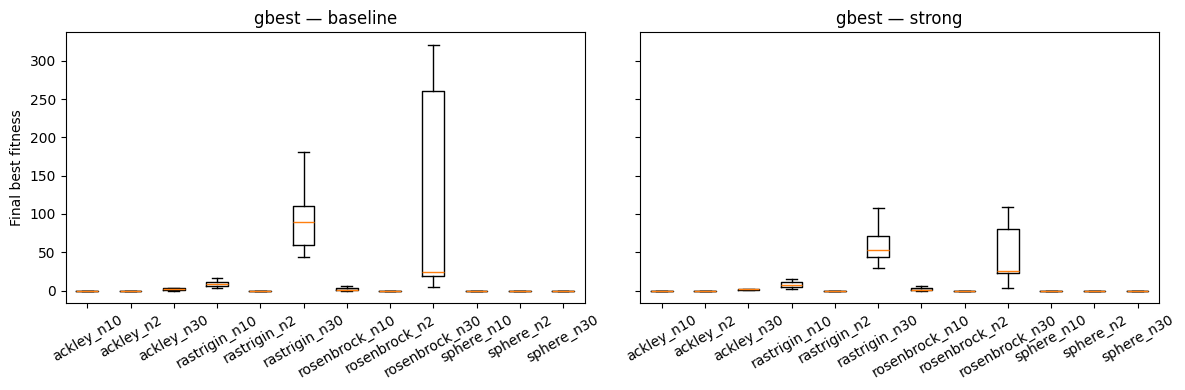

Saved /Users/kristina/ACIT4610_exam/PSO/results/boxplot_gbest_baseline_vs_strong_nb.png


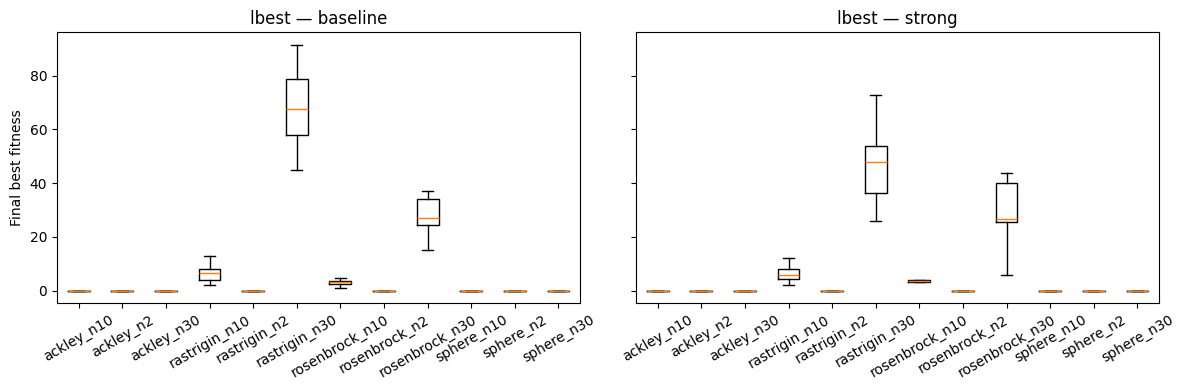

Saved /Users/kristina/ACIT4610_exam/PSO/results/boxplot_lbest_baseline_vs_strong_nb.png


In [38]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def load_runs(folder: Path):
    runs_g = pd.read_csv(folder / "runs_gbest.csv")
    runs_l = pd.read_csv(folder / "runs_lbest.csv")
    # ensure numeric
    runs_g["best_f"] = pd.to_numeric(runs_g["best_f"], errors="coerce")
    runs_l["best_f"] = pd.to_numeric(runs_l["best_f"], errors="coerce")
    return runs_g, runs_l

def boxplot_from_runs_df(df: pd.DataFrame, title: str, outpath: Path):
    df = df.copy()
    df["combo"] = df["func"] + "_n" + df["n"].astype(str)
    order = sorted(df["combo"].unique())
    data = [df.loc[df["combo"] == c, "best_f"].values for c in order]
    plt.figure()
    plt.boxplot(data, tick_labels=order, showfliers=False)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Final best fitness")
    plt.title(title)
    plt.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    print("Saved", outpath)

# -------- SIDE-BY-SIDE comparison (baseline vs strong) --------
runs_g_B, runs_l_B = load_runs(BASELINE)
runs_g_S, runs_l_S = load_runs(STRONG)

def twobox(df_left, df_right, title_left, title_right, outpath: Path):
    def prep(df):
        d = df.copy()
        d["combo"] = d["func"] + "_n" + d["n"].astype(str)
        order = sorted(d["combo"].unique())
        data = [d.loc[d["combo"] == c, "best_f"].values for c in order]
        return order, data
    orderL, dataL = prep(df_left)
    orderR, dataR = prep(df_right)

    # keep a common x-label order for readability (use left's order)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    axes[0].boxplot(dataL, tick_labels=orderL, showfliers=False)
    axes[0].set_title(title_left); axes[0].set_ylabel("Final best fitness")
    axes[0].tick_params(axis="x", labelrotation=30)
    axes[1].boxplot(dataR, tick_labels=orderL, showfliers=False)
    axes[1].set_title(title_right)
    axes[1].tick_params(axis="x", labelrotation=30)
    fig.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outpath, bbox_inches="tight")
    plt.show()
    print("Saved", outpath)

# Compare gbest
twobox(
    runs_g_B, runs_g_S,
    "gbest — baseline", "gbest — strong",
    BASELINE.parent / "boxplot_gbest_baseline_vs_strong_nb.png"
)

# Compare lbest
twobox(
    runs_l_B, runs_l_S,
    "lbest — baseline", "lbest — strong",
    BASELINE.parent / "boxplot_lbest_baseline_vs_strong_nb.png"
)

## Convergence

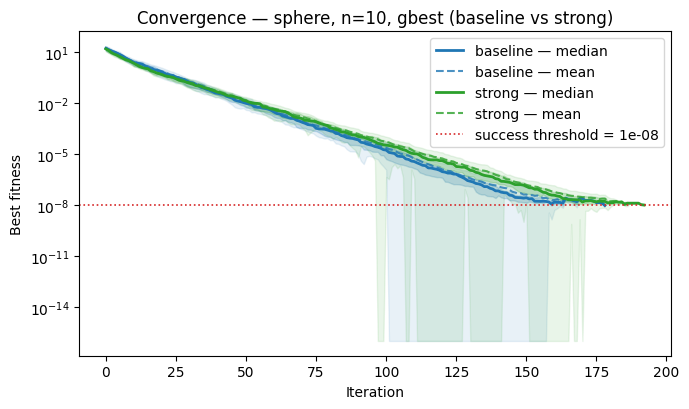

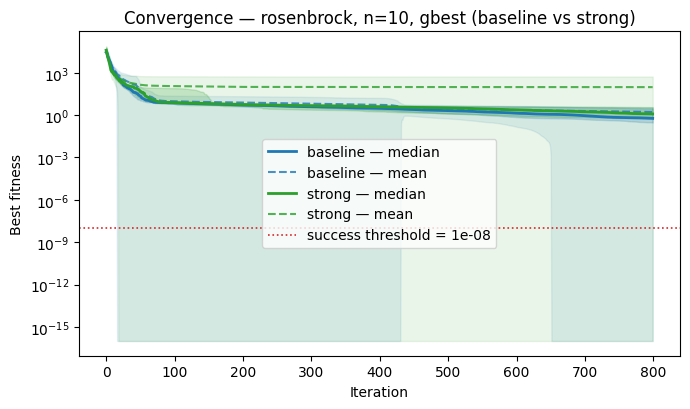

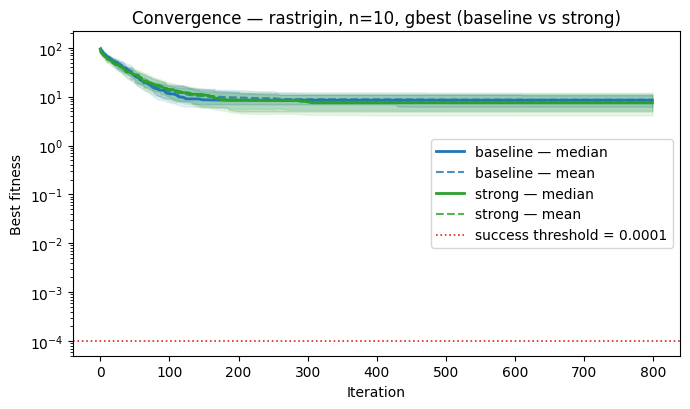

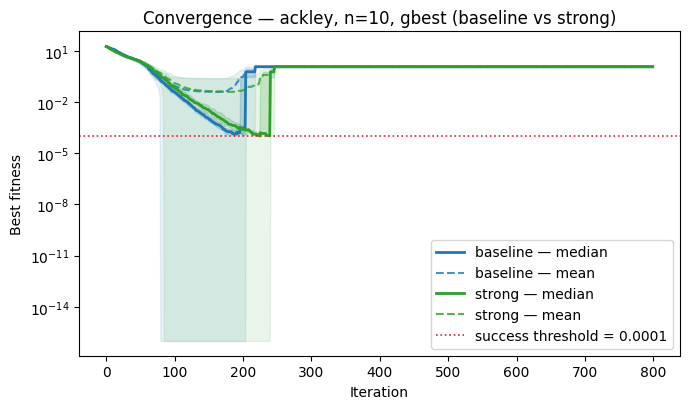

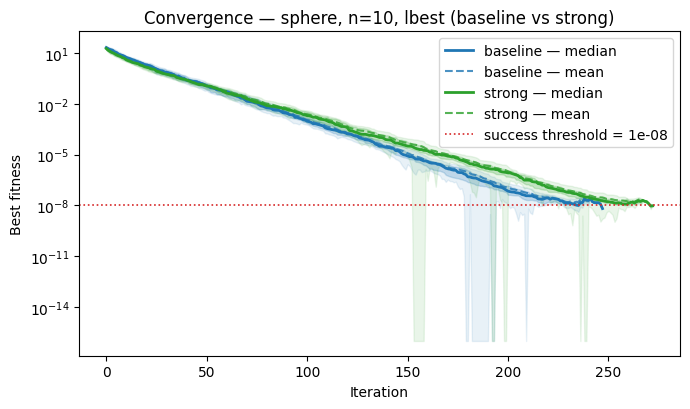

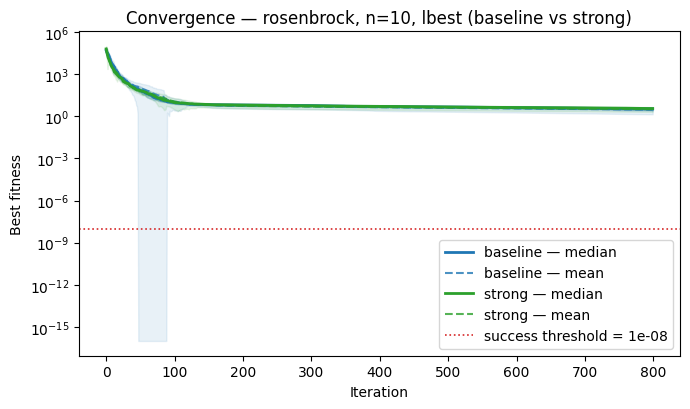

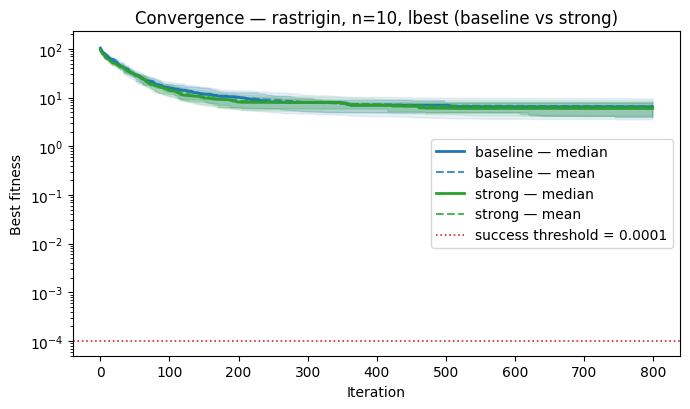

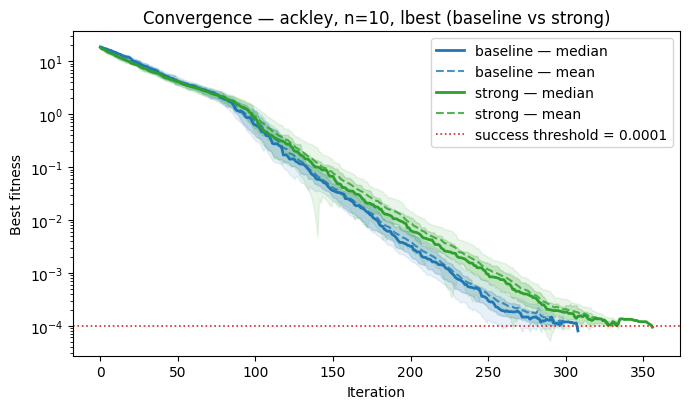

In [45]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# ---- plotting + numeric safety constants ----
EPS = 1e-16  # anything below this is treated as 0 for log-scale
COLORS = dict(base="#1f77b4", str="#2ca02c")  # blue/green for lines

# Optional: success thresholds to display as a horizontal reference line
SUCCESS_THRESHOLDS = {
    "sphere": 1e-8,
    "rosenbrock": 1e-8,
    "rastrigin": 1e-4,
    "ackley": 1e-4,
}

def _as_list(a):
    return a if isinstance(a, (list, tuple)) else [a]

def load_curve_matrix(folder: Path, topo: str, fname: str, n: int):
    """
    Load per-run gbest curves for (function=fname, dimension=n, topology=topo).
    Returns a list of 1D numpy arrays (runs can have different lengths).
    """
    curves_dir = folder / f"curves_{topo}"
    paths = sorted(curves_dir.glob(f"{fname}_n{n}_run*.npy"))
    return [np.load(p) for p in paths]

def summarize_ragged(curves, stat="mean"):
    """
    Aggregate ragged (different-length) curves per iteration without truncation.
    Returns x, center, low, high where:
      - stat='mean'   -> center=mean, band=±std
      - stat='median' -> center=median, band = [p25, p75]
    """
    if not curves:
        return None

    Tmax = max(map(len, curves))
    vals_per_t = [np.array([c[t] for c in curves if len(c) > t], float) for t in range(Tmax)]
    x = np.arange(Tmax, dtype=int)

    if stat == "mean":
        center = np.array([v.mean() for v in vals_per_t])
        std    = np.array([v.std(ddof=0) for v in vals_per_t])
        low, high = center - std, center + std
    else:
        center = np.array([np.median(v)     for v in vals_per_t])
        p25    = np.array([np.percentile(v, 25) for v in vals_per_t])
        p75    = np.array([np.percentile(v, 75) for v in vals_per_t])
        low, high = p25, p75
    return x, center, low, high

def _clip_for_log(y):
    """Clip array to be >= EPS so log-scale never shows 'below zero' artefacts."""
    return np.maximum(y, EPS)

def _safe_band(ax, x, low, high, use_log, alpha=0.18, color=None, label=None):
    if use_log:
        low  = _clip_for_log(low)
        high = _clip_for_log(high)
    ax.fill_between(x, low, high, alpha=alpha, color=color, label=label)

def plot_overlay_for(
    fname: str, topo: str, n: int,
    use_log: bool = True,
    out_dir: Path | None = None,
    baseline_root: Path = None, strong_root: Path = None,
    show_threshold: bool = True,
):
    """Median/IQR and Mean±Std overlays for baseline vs strong, with safe log plotting."""
    Mb = load_curve_matrix(baseline_root, topo, fname, n) if baseline_root else []
    Ms = load_curve_matrix(strong_root,   topo, fname, n) if strong_root   else []

    if not Mb and not Ms:
        print(f"[WARN] No curves for {fname}, n={n}, {topo}")
        return

    fig, ax = plt.subplots(figsize=(7.0, 4.2))

    # Baseline: median/IQR (solid) + mean±std (dashed)
    if Mb:
        xb_m, mb_m, lb_m, hb_m = summarize_ragged(Mb, stat="median")
        xb,   mb,   lb,   hb   = summarize_ragged(Mb, stat="mean")
        if use_log:
            mb_m, mb = _clip_for_log(mb_m), _clip_for_log(mb)
        ax.plot(xb_m, mb_m, color=COLORS["base"], lw=2.0, label="baseline — median")
        _safe_band(ax, xb_m, lb_m, hb_m, use_log, alpha=0.20, color=COLORS["base"])
        ax.plot(xb,   mb,   color=COLORS["base"], ls="--", alpha=0.8, label="baseline — mean")
        _safe_band(ax, xb,   lb,   hb,   use_log, alpha=0.10, color=COLORS["base"])

    # Strong
    if Ms:
        xs_m, ms_m, ls_m, hs_m = summarize_ragged(Ms, stat="median")
        xs,   ms,   ls,   hs   = summarize_ragged(Ms, stat="mean")
        if use_log:
            ms_m, ms = _clip_for_log(ms_m), _clip_for_log(ms)
        ax.plot(xs_m, ms_m, color=COLORS["str"], lw=2.0, label="strong — median")
        _safe_band(ax, xs_m, ls_m, hs_m, use_log, alpha=0.20, color=COLORS["str"])
        ax.plot(xs,   ms,   color=COLORS["str"], ls="--", alpha=0.8, label="strong — mean")
        _safe_band(ax, xs,   ls,   hs,   use_log, alpha=0.10, color=COLORS["str"])

    # Optional success-threshold line
    if show_threshold and fname in SUCCESS_THRESHOLDS:
        thr = SUCCESS_THRESHOLDS[fname]
        y_thr = max(thr, EPS) if use_log else thr
        ax.axhline(y_thr, color="#d62728", lw=1.2, ls=":", label=f"success threshold = {thr:g}")

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best fitness")
    if use_log:
        ax.set_yscale("log")
    ax.set_title(f"Convergence — {fname}, n={n}, {topo} (baseline vs strong)")
    ax.legend(frameon=True)
    fig.tight_layout()

    # Save + show inline
    if out_dir is not None:
        out_dir.mkdir(parents=True, exist_ok=True)
        out = out_dir / f"conv_{fname}_n{n}_{topo}_baseline_vs_strong.png"
        fig.savefig(out, bbox_inches="tight", dpi=200)
        # print("Saved", out)
    display(fig)
    plt.close(fig)

# ---- Driving code (n = 10 recommended by the brief) ----
FUNCS = ["sphere", "rosenbrock", "rastrigin", "ackley"]
TOPOLOGIES = ["gbest", "lbest"]
N_FOR_PLOT = 10
USE_LOG_Y = True


for topo in TOPOLOGIES:
    for fname in FUNCS:
        plot_overlay_for(
            fname, topo, n=N_FOR_PLOT, use_log=USE_LOG_Y,
            out_dir=BASELINE.parent,
            baseline_root=BASELINE, strong_root=STRONG,
            show_threshold=True,
        )


## PSO parameter sweep & sensitivity plots

,function,topology,w,c1,c2,success_rate,median_final_fitness,runs,n,iterations,swarm_size
0,sphere,gbest,0.40,1.00,1.00,0.00,0.35,30,10,300,30
1,sphere,gbest,0.40,1.00,1.50,0.00,0.00,30,10,300,30
2,sphere,gbest,0.40,1.00,2.00,0.93,0.00,30,10,300,30
3,sphere,gbest,0.40,1.50,1.00,0.00,0.17,30,10,300,30
4,sphere,gbest,0.40,1.50,1.50,0.13,0.00,30,10,300,30
5,sphere,gbest,0.40,1.50,2.00,1.00,0.00,30,10,300,30
6,sphere,gbest,0.40,2.00,1.00,0.00,0.12,30,10,300,30
7,sphere,gbest,0.40,2.00,1.50,0.63,0.00,30,10,300,30
8,sphere,gbest,0.40,2.00,2.00,1.00,0.00,30,10,300,30
9,sphere,gbest,0.60,1.00,1.00,0.63,0.00,30,10,300,30


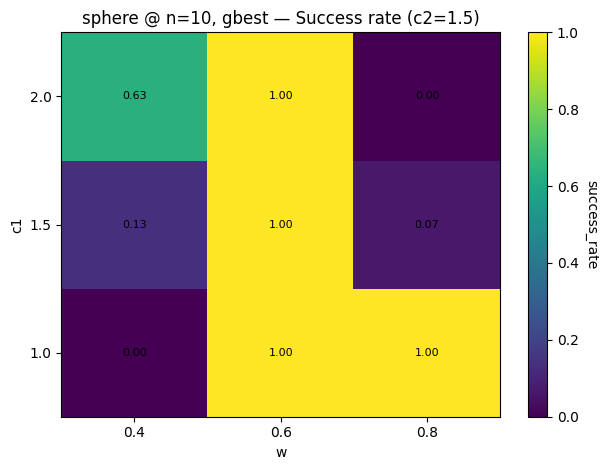

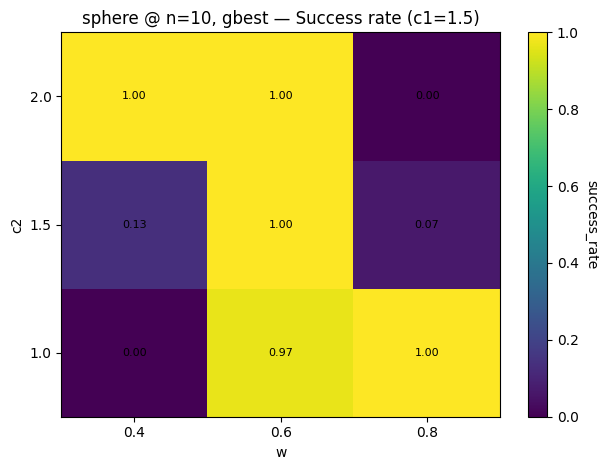

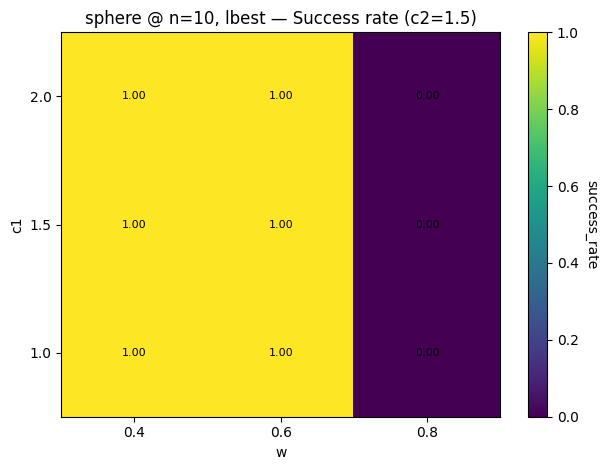

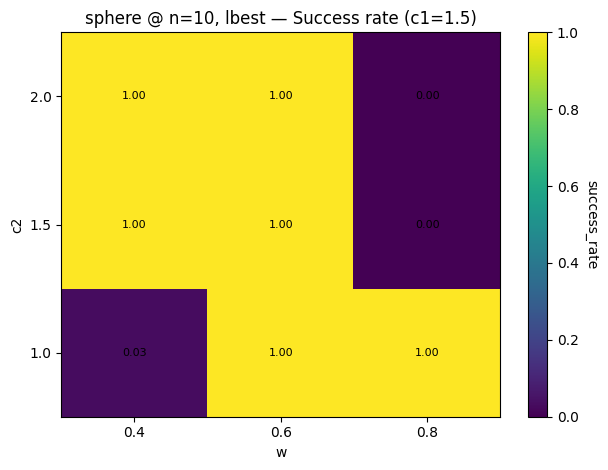

Using 'closeness' metric for rosenbrock (gbest) — mean success=0.000, spread=0.000


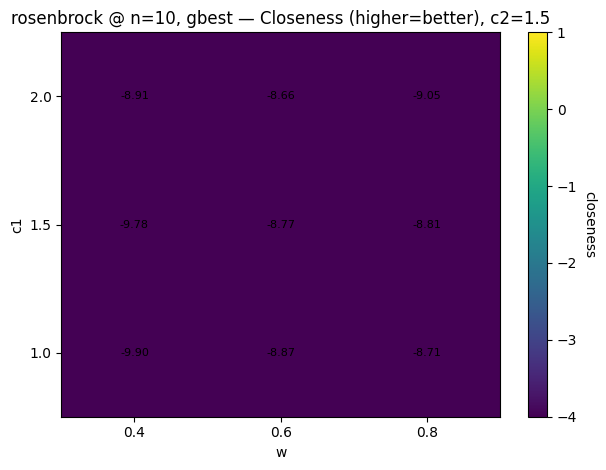

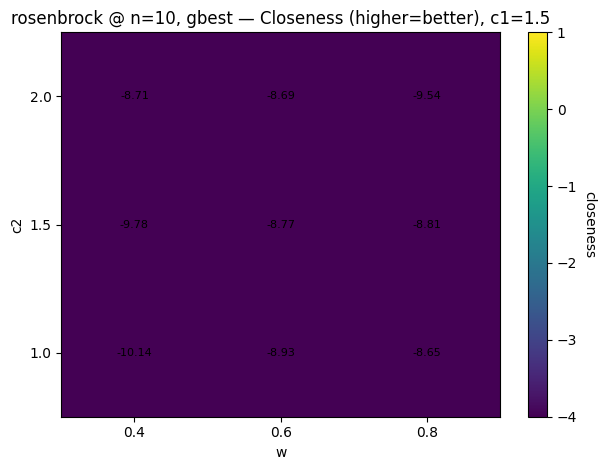

Using 'closeness' metric for rosenbrock (lbest) — mean success=0.000, spread=0.000


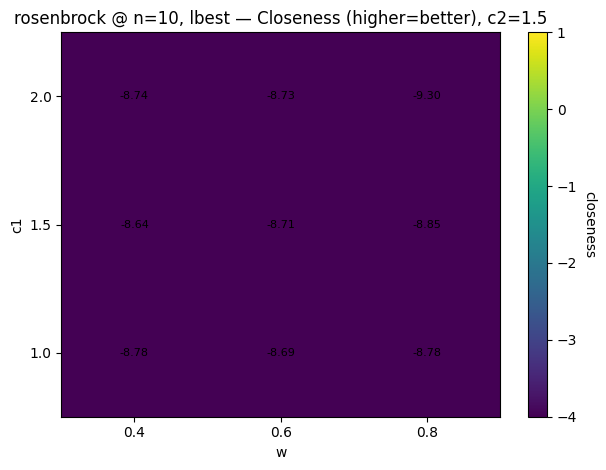

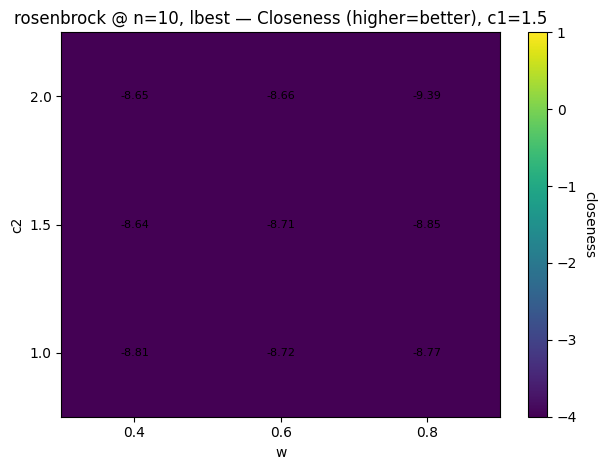

Using 'closeness' metric for rastrigin (gbest) — mean success=0.000, spread=0.000


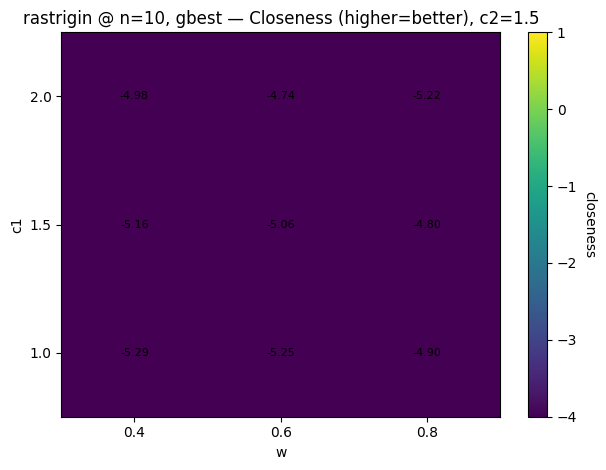

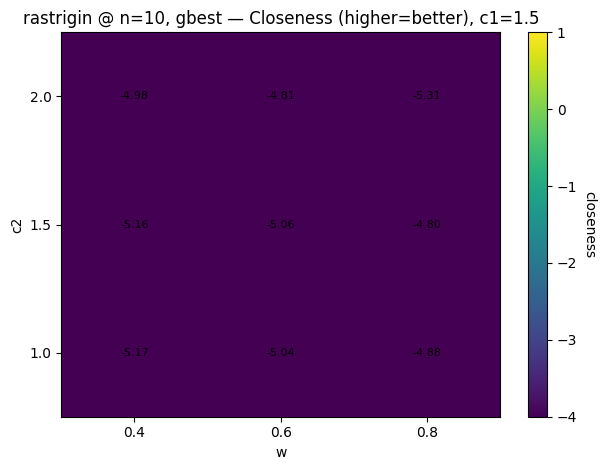

Using 'closeness' metric for rastrigin (lbest) — mean success=0.000, spread=0.000


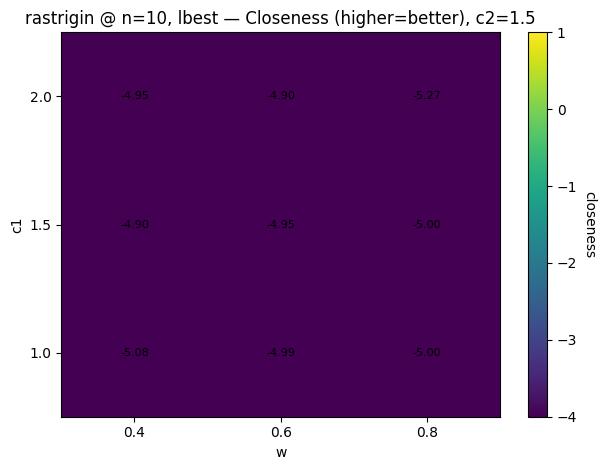

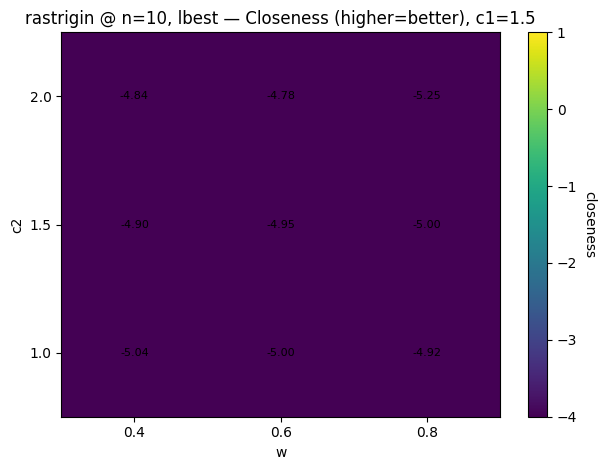

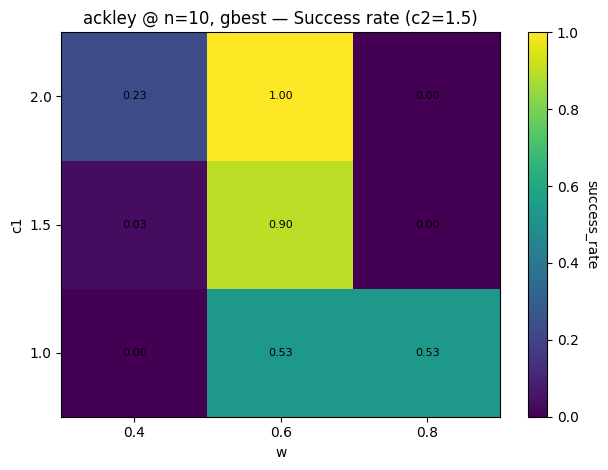

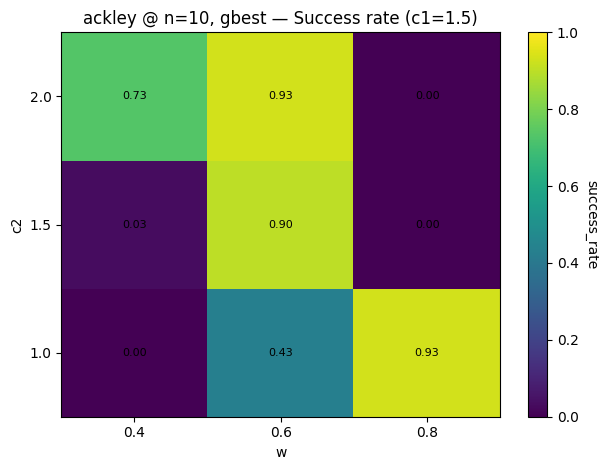

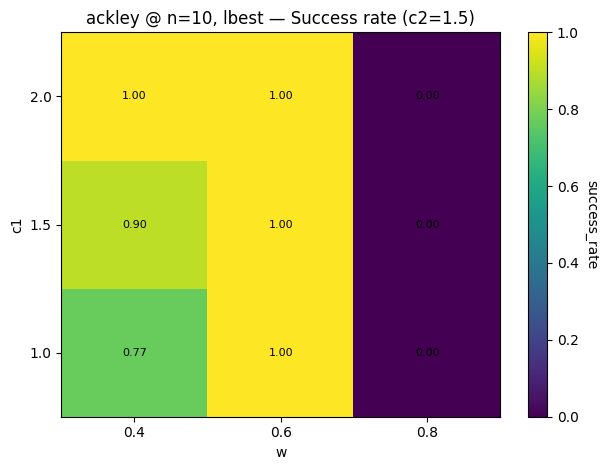

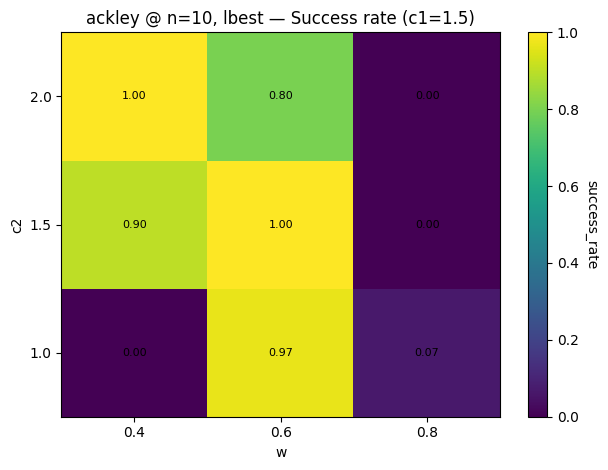

In [52]:
# === PSO parameter sweep & sensitivity plots (using your pso_run + functions.py) ===
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from config import PSOParams
from functions import FUNCTIONS, SUCCESS_THRESHOLDS

# -----------------------------
# CONFIG
# -----------------------------
functions = ["sphere", "rosenbrock", "rastrigin", "ackley"]
n = 10
topologies = ["gbest", "lbest"]

# Parameter grid
W_VALUES  = [0.4, 0.6, 0.8]   # inertia ω
C1_VALUES = [1.0, 1.5, 2.0]   # cognitive c1
C2_VALUES = [1.0, 1.5, 2.0]   # social c2

runs_per_combo = 30
iterations = 300 #tAkes approx 10 min to run 800 iterations, adjust to 300 if necessary
swarm_size = 30
vmax_frac = 0.5
ring_k = 4

def run_pso_once(func_name, n, topology, w, c1, c2, iterations, swarm_size, seed):
    f      = FUNCTIONS[func_name]["f"]
    bounds = FUNCTIONS[func_name]["bounds"]
    thr    = SUCCESS_THRESHOLDS[func_name]

    rng = np.random.default_rng(seed)
    params = PSOParams(
        swarm_size=swarm_size,
        iters=iterations,
        w=float(w),
        c1=float(c1),
        c2=float(c2),
        vmax_frac=float(vmax_frac),
        topology=topology,
    )

    res = pso_run(
        f=f,
        bounds=bounds,
        dim=n,
        params=params,
        rng=rng,
        stop_threshold=thr,
    )
    return {"final_best_fitness": res["best_f"]}

# -----------------------------
# Sweep and collect results
# -----------------------------
records = []

for func_name in functions:
    thr = SUCCESS_THRESHOLDS[func_name]
    for topology in topologies:
        for w, c1, c2 in itertools.product(W_VALUES, C1_VALUES, C2_VALUES):
            final_vals = []
            for seed in range(runs_per_combo):
                out = run_pso_once(
                    func_name=func_name, n=n, topology=topology,
                    w=w, c1=c1, c2=c2,
                    iterations=iterations, swarm_size=swarm_size, seed=seed
                )
                final_vals.append(out["final_best_fitness"])
            final_vals = np.array(final_vals, dtype=float)
            success_rate = float(np.mean(final_vals <= thr))
            median_fit   = float(np.median(final_vals))
            records.append({
                "function": func_name,
                "topology": topology,
                "w": w, "c1": c1, "c2": c2,
                "success_rate": success_rate,
                "median_final_fitness": median_fit,
                "runs": runs_per_combo,
                "n": n, "iterations": iterations, "swarm_size": swarm_size,
            })

df_sweep = pd.DataFrame(records)
pd.set_option('display.max_rows', None)   # show all rows
pd.set_option('display.max_columns', None)  # (optional) show all columns
display(df_sweep)

# -----------------------------
# Heatmap helper
# -----------------------------
def plot_heatmap(df_sub, value_col, title, x_vals, y_vals, x_label, y_label, vmin=None, vmax=None):
    Z = np.full((len(y_vals), len(x_vals)), np.nan, dtype=float)
    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            sel = df_sub[(df_sub[x_label.lower()] == x) & (df_sub[y_label.lower()] == y)][value_col]
            if len(sel):
                Z[i, j] = float(sel.iloc[0])

    fig, ax = plt.subplots(figsize=(6.3, 4.8))
    im = ax.imshow(Z, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(len(x_vals))); ax.set_xticklabels([str(v) for v in x_vals])
    ax.set_yticks(range(len(y_vals))); ax.set_yticklabels([str(v) for v in y_vals])
    ax.set_xlabel(x_label); ax.set_ylabel(y_label)
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(value_col, rotation=270, labelpad=14)
    for i in range(len(y_vals)):
        for j in range(len(x_vals)):
            val = Z[i, j]
            ax.text(j, i, ("nan" if not np.isfinite(val) else f"{val:.2f}"),
                    ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

def add_closeness_column(df, func_name):
    thr = SUCCESS_THRESHOLDS[func_name]
    # closeness = -log10(median / threshold); higher is better, 0 == at threshold
    vals = df["median_final_fitness"].clip(lower=np.finfo(float).tiny)
    df = df.copy()
    df["closeness"] = -np.log10(vals / thr)
    return df

# Use the same W_VALUES, C1_VALUES, C2_VALUES, n, topologies from the sweep cell
for func_name in functions:
    for topology in topologies:
        sub = df_sweep[(df_sweep.function == func_name) & (df_sweep.topology == topology)]

        mean_sr = sub["success_rate"].mean()
        spread_sr = sub["success_rate"].max() - sub["success_rate"].min()
        use_closeness = (mean_sr < 0.05) or (spread_sr < 0.05)

        if use_closeness:
            print(f"Using 'closeness' metric for {func_name} ({topology}) — "
                  f"mean success={mean_sr:.3f}, spread={spread_sr:.3f}")
            sub_c = add_closeness_column(sub, func_name)
            fixed_c2 = C2_VALUES[1]
            s1 = sub_c[sub_c["c2"] == fixed_c2]
            plot_heatmap(
                s1, value_col="closeness",
                title=f"{func_name} @ n={n}, {topology} — Closeness (higher=better), c2={fixed_c2}",
                x_vals=W_VALUES, y_vals=C1_VALUES,
                x_label="w", y_label="c1",
                vmin=-4.0, vmax=1.0
            )

            fixed_c1 = C1_VALUES[1]
            s2 = sub_c[sub_c["c1"] == fixed_c1]
            plot_heatmap(
                s2, value_col="closeness",
                title=f"{func_name} @ n={n}, {topology} — Closeness (higher=better), c1={fixed_c1}",
                x_vals=W_VALUES, y_vals=C2_VALUES,
                x_label="w", y_label="c2",
                vmin=-4.0, vmax=1.0
            )
        else:
            # Keep the success-rate heatmaps when informative
            fixed_c2 = C2_VALUES[1]
            s1 = sub[sub["c2"] == fixed_c2]
            plot_heatmap(
                s1, value_col="success_rate",
                title=f"{func_name} @ n={n}, {topology} — Success rate (c2={fixed_c2})",
                x_vals=W_VALUES, y_vals=C1_VALUES,
                x_label="w", y_label="c1",
                vmin=0.0, vmax=1.0
            )

            fixed_c1 = C1_VALUES[1]
            s2 = sub[sub["c1"] == fixed_c1]
            plot_heatmap(
                s2, value_col="success_rate",
                title=f"{func_name} @ n={n}, {topology} — Success rate (c1={fixed_c1})",
                x_vals=W_VALUES, y_vals=C2_VALUES,
                x_label="w", y_label="c2",
                vmin=0.0, vmax=1.0
            )